# Emo-Check: Vision Transformer (ViT-B/16) 転移学習

画像の「エモさ」を判定するための二値分類モデルをViT-B/16ベースで学習します。

- **class_0**: Not Emo（エモくない画像）
- **class_1**: Emo（エモい画像）

In [1]:
# 必要なライブラリのインストール
!pip install torch torchvision pillow matplotlib tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# GPU設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')

Using device: cpu


In [3]:
# ハイパーパラメータ
BATCH_SIZE = 16  # ViTはメモリを多く使用するため小さめに
NUM_EPOCHS = 20
LEARNING_RATE = 0.0001  # ViTは小さい学習率が効果的
NUM_CLASSES = 2
IMAGE_SIZE = 224

# データセットパス
DATA_DIR = './dataset'

In [4]:
# データ拡張と前処理（ViT用）
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# データセットの読み込み
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transforms)

# 学習/検証データの分割 (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# 検証データには拡張なしの変換を適用
val_dataset.dataset.transform = val_transforms

print(f'Total images: {len(full_dataset)}')
print(f'Training images: {train_size}')
print(f'Validation images: {val_size}')
print(f'Classes: {full_dataset.classes}')

Total images: 123
Training images: 98
Validation images: 25
Classes: ['class_0', 'class_1']


In [6]:
# DataLoader作成
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# 入力データのテンソル形状の確認
sample_images, sample_labels = next(iter(train_loader))
print(f'=== 入力データのテンソル形状 ===')
print(f'画像バッチの形状: {sample_images.shape}')
print(f'  - バッチサイズ: {sample_images.shape[0]}')
print(f'  - チャンネル数: {sample_images.shape[1]} (RGB)')
print(f'  - 画像サイズ: {sample_images.shape[2]} x {sample_images.shape[3]} pixels')
print(f'ラベルの形状: {sample_labels.shape}')
print(f'ラベルの例: {sample_labels[:5].tolist()}')

/Users/namboshunsuke/my_projects/Emo-Check/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== 入力データのテンソル形状 ===
画像バッチの形状: torch.Size([16, 3, 224, 224])
  - バッチサイズ: 16
  - チャンネル数: 3 (RGB)
  - 画像サイズ: 224 x 224 pixels
ラベルの形状: torch.Size([16])
ラベルの例: [0, 1, 0, 1, 1]


In [7]:
# Vision Transformer (ViT-B/16) モデルの構築（転移学習）
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

# 最終層（heads）を二値分類用に置き換え
num_features = model.heads.head.in_features
model.heads.head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_features, 256),
    nn.GELU(),
    nn.Dropout(p=0.3),
    nn.Linear(256, NUM_CLASSES)
)

model = model.to(device)
print(f'ViT-B/16 model loaded and moved to {device}')

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /Users/namboshunsuke/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:35<00:00, 9.71MB/s] 


ViT-B/16 model loaded and moved to cpu


In [8]:
# 損失関数と最適化
criterion = nn.CrossEntropyLoss()

# ViT用の最適化設定（異なる学習率を層ごとに適用）
# ヘッド部分は高い学習率、事前学習部分は低い学習率
param_groups = [
    {'params': [p for n, p in model.named_parameters() if 'heads' not in n], 'lr': LEARNING_RATE * 0.1},
    {'params': model.heads.parameters(), 'lr': LEARNING_RATE}
]
optimizer = optim.AdamW(param_groups, weight_decay=0.05)

# Warmup付きコサインアニーリング
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

In [9]:
# 学習関数
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # 勾配クリッピング（ViTの安定性向上）
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    return running_loss / len(loader), 100. * correct / total

In [10]:
# 検証関数
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

In [11]:
# 学習ループ
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    print(f'\n=== Epoch {epoch+1}/{NUM_EPOCHS} ===')
    
    # 学習
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # 検証
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # 学習率更新
    scheduler.step()
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Learning Rate (backbone): {current_lr:.6f}')
    
    # ベストモデルの保存
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, 'vit_b16_best.pth')
        print(f'✓ Best model saved! (Val Acc: {val_acc:.2f}%)')


=== Epoch 1/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.16s/it]


Train Loss: 0.6682, Train Acc: 57.14%
Val Loss: 0.6748, Val Acc: 60.00%
Learning Rate (backbone): 0.000009
✓ Best model saved! (Val Acc: 60.00%)

=== Epoch 2/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.19s/it]


Train Loss: 0.5585, Train Acc: 75.51%
Val Loss: 0.6138, Val Acc: 76.00%
Learning Rate (backbone): 0.000007
✓ Best model saved! (Val Acc: 76.00%)

=== Epoch 3/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.21s/it]


Train Loss: 0.5074, Train Acc: 91.84%
Val Loss: 0.5798, Val Acc: 80.00%
Learning Rate (backbone): 0.000003
✓ Best model saved! (Val Acc: 80.00%)

=== Epoch 4/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.14s/it]


Train Loss: 0.4581, Train Acc: 96.94%
Val Loss: 0.5603, Val Acc: 80.00%
Learning Rate (backbone): 0.000001

=== Epoch 5/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.13s/it]


Train Loss: 0.4406, Train Acc: 93.88%
Val Loss: 0.5545, Val Acc: 80.00%
Learning Rate (backbone): 0.000010

=== Epoch 6/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.18s/it]


Train Loss: 0.3928, Train Acc: 92.86%
Val Loss: 0.4961, Val Acc: 80.00%
Learning Rate (backbone): 0.000010

=== Epoch 7/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.23s/it]


Train Loss: 0.3115, Train Acc: 97.96%
Val Loss: 0.4383, Val Acc: 80.00%
Learning Rate (backbone): 0.000009

=== Epoch 8/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.29s/it]


Train Loss: 0.1869, Train Acc: 100.00%
Val Loss: 0.3777, Val Acc: 84.00%
Learning Rate (backbone): 0.000008
✓ Best model saved! (Val Acc: 84.00%)

=== Epoch 9/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.16s/it]


Train Loss: 0.1530, Train Acc: 100.00%
Val Loss: 0.3268, Val Acc: 80.00%
Learning Rate (backbone): 0.000007

=== Epoch 10/20 ===


Validation: 100%|██████████| 2/2 [00:15<00:00,  7.89s/it]


Train Loss: 0.0773, Train Acc: 100.00%
Val Loss: 0.3025, Val Acc: 84.00%
Learning Rate (backbone): 0.000005

=== Epoch 11/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.22s/it]


Train Loss: 0.0498, Train Acc: 100.00%
Val Loss: 0.2872, Val Acc: 84.00%
Learning Rate (backbone): 0.000003

=== Epoch 12/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.22s/it]


Train Loss: 0.0363, Train Acc: 100.00%
Val Loss: 0.2726, Val Acc: 84.00%
Learning Rate (backbone): 0.000002

=== Epoch 13/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.23s/it]


Train Loss: 0.0268, Train Acc: 100.00%
Val Loss: 0.2648, Val Acc: 84.00%
Learning Rate (backbone): 0.000001

=== Epoch 14/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.20s/it]


Train Loss: 0.0260, Train Acc: 100.00%
Val Loss: 0.2622, Val Acc: 84.00%
Learning Rate (backbone): 0.000000

=== Epoch 15/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.25s/it]


Train Loss: 0.0261, Train Acc: 100.00%
Val Loss: 0.2615, Val Acc: 84.00%
Learning Rate (backbone): 0.000010

=== Epoch 16/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.45s/it]


Train Loss: 0.0176, Train Acc: 100.00%
Val Loss: 0.2454, Val Acc: 84.00%
Learning Rate (backbone): 0.000010

=== Epoch 17/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.28s/it]


Train Loss: 0.0091, Train Acc: 100.00%
Val Loss: 0.2453, Val Acc: 84.00%
Learning Rate (backbone): 0.000010

=== Epoch 18/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.21s/it]


Train Loss: 0.0053, Train Acc: 100.00%
Val Loss: 0.2475, Val Acc: 84.00%
Learning Rate (backbone): 0.000009

=== Epoch 19/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.22s/it]


Train Loss: 0.0034, Train Acc: 100.00%
Val Loss: 0.2485, Val Acc: 84.00%
Learning Rate (backbone): 0.000009

=== Epoch 20/20 ===


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.27s/it]

Train Loss: 0.0027, Train Acc: 100.00%
Val Loss: 0.2479, Val Acc: 84.00%
Learning Rate (backbone): 0.000009


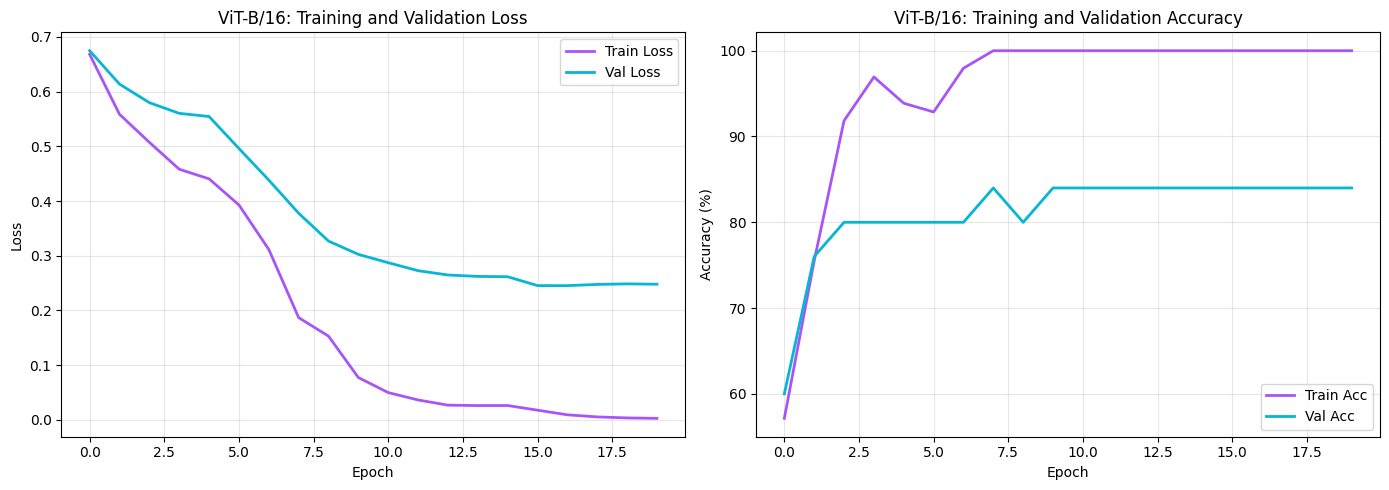


🎉 Training Complete!
Best Validation Accuracy: 84.00%


In [12]:
# 学習曲線のプロット
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(train_losses, label='Train Loss', color='#a855f7', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', color='#06b6d4', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('ViT-B/16: Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(train_accs, label='Train Acc', color='#a855f7', linewidth=2)
axes[1].plot(val_accs, label='Val Acc', color='#06b6d4', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('ViT-B/16: Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vit_b16_training_curves.png', dpi=150)
plt.show()

print(f'\n🎉 Training Complete!')
print(f'Best Validation Accuracy: {best_val_acc:.2f}%')

In [13]:
# 推論用モデルとして保存（state_dictのみ）
# ベストモデルをロード
checkpoint = torch.load('vit_b16_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# 推論用に保存
torch.save(model.state_dict(), 'vit_b16.pth')
print('✓ Model saved as vit_b16.pth')
print(f'  - Best Epoch: {checkpoint["epoch"] + 1}')
print(f'  - Val Accuracy: {checkpoint["val_acc"]:.2f}%')

✓ Model saved as vit_b16.pth
  - Best Epoch: 8
  - Val Accuracy: 84.00%


In [14]:
# 推論テスト
from PIL import Image

def predict_emo_score_vit(image_path, model, device):
    """単一画像のエモ度を予測（ViT用）"""
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        emo_score = probabilities[0][1].item()  # class_1 (Emo) の確率
    
    return emo_score * 100  # パーセンテージで返す

# テスト用: データセット内の画像でテスト（存在する場合）
# score = predict_emo_score_vit('path/to/test/image.jpg', model, device)
# print(f'Emo Score: {score:.1f}%')

In [15]:
# Attention Mapの可視化（オプション）
def visualize_attention(model, image_path, device):
    """ViTのAttentionを可視化"""
    from PIL import Image
    import numpy as np
    
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Attention weightを取得するためのフック
    attention_weights = []
    
    def get_attention(module, input, output):
        attention_weights.append(output)
    
    # 最後のTransformerブロックのself-attentionにフックを追加
    # 注: この実装はtorchvisionのViTの内部構造に依存
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        emo_score = probabilities[0][1].item()
    
    return emo_score * 100

print('Attention visualization function defined (optional use)')

Attention visualization function defined (optional use)
